In [10]:
# Gemstone Analysis using ResNet18 and ResNet50

ResNet18 and ResNet50 models pretrained on ImageNet dataset was applied to the gemstone images for feature extraction. 

In [11]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
! [ ! -z "$COLAB_GPU" ] && pip install torch torchvision pillow==7.1.2 skorch

In [ ]:
!pip install skorch

In [23]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import skorch
from skorch.callbacks import LRScheduler, Checkpoint
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os 
import shutil
import pickle
import seaborn as sns
from skorch import NeuralNetClassifier
from sklearn.metrics import accuracy_score, top_k_accuracy_score, confusion_matrix
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [14]:
print(torch.cuda.get_device_name(0))

Tesla T4


In [24]:
shutil.rmtree('/content/gemstones/')

In [25]:
# Import dataset
! git clone https://github.com/RHenigan/gemstones

Cloning into 'gemstones'...
remote: Enumerating objects: 6561, done.
remote: Counting objects: 100% (3259/3259), done.
remote: Compressing objects: 100% (3251/3251), done.
remote: Total 6561 (delta 8), reused 3259 (delta 8), pack-reused 3302
Receiving objects: 100% (6561/6561), 82.63 MiB | 39.48 MiB/s, done.
Resolving deltas: 100% (226/226), done.


In [26]:
# Set seed to 1
seed = 1
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [27]:
# Data augmentation and normalization for training set
# Just normalization for test set
data_means = [0.485, 0.456, 0.406]
data_stds = [0.229, 0.224, 0.225]

data_transforms = {
    'train_masked': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
    'test_masked': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
}

In [28]:
# Define the path where the dataset was saved
data_dir = '/content/gemstones/'

In [30]:
# Load the masked images
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train_masked', 'test_masked']}

# Compute the weight for each image
def compute_weight(images):                        
    count = [0] * 85                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * 85                                     
    N = float(sum(count))                                                   
    for i in range(85):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, (image_datasets, label) in enumerate(images):                                          
        weight[idx] = weight_per_class[label]                                  
    return weight                                                                
                                                                                
# Create a weighted sampler for training data                   
weights = compute_weight(image_datasets['train_masked'])                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights), replacement=True)                     

dataloaders = {}                                                                               
dataloaders['train_masked'] = torch.utils.data.DataLoader(image_datasets['train_masked'], batch_size=16,                              
                                                             sampler = sampler, num_workers=2)    

# Create sampler for test data
dataloaders['test_masked'] = torch.utils.data.DataLoader(image_datasets['test_masked'], batch_size=16,
                                             shuffle=True, num_workers=2)

In [31]:
# Display dataset sizes and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['train_masked', 'test_masked']}
class_names = image_datasets['test_masked'].classes
print(dataset_sizes)
print(class_names)

{'train_masked': 2796, 'test_masked': 355}
['Alexandrite', 'Almandine', 'Amazonite', 'Amber', 'Amethyst', 'Ametrine', 'Andalusite', 'Andradite', 'Aquamarine', 'Aventurine Green', 'Aventurine Yellow', 'Benitoite', 'Beryl Golden', 'Bixbite', 'Bloodstone', 'Blue Lace Agate', 'Carnelian', 'Cats Eye', 'Chalcedony', 'Chalcedony Blue', 'Chrome Diopside', 'Chrysoberyl', 'Chrysocolla', 'Chrysoprase', 'Citrine', 'Coral', 'Diamond', 'Diaspore', 'Dumortierite', 'Emerald', 'Fluorite', 'Garnet Red', 'Goshenite', 'Grossular', 'Hessonite', 'Hiddenite', 'Iolite', 'Jade', 'Jasper', 'Kunzite', 'Kyanite', 'Labradorite', 'Lapis Lazuli', 'Larimar', 'Malachite', 'Moonstone', 'Morganite', 'Onyx Black', 'Onyx Green', 'Onyx Red', 'Opal', 'Pearl', 'Peridot', 'Prehnite', 'Pyrite', 'Pyrope', 'Quartz Beer', 'Quartz Lemon', 'Quartz Rose', 'Quartz Rutilated', 'Quartz Smoky', 'Rhodochrosite', 'Rhodolite', 'Rhodonite', 'Ruby', 'Sapphire Blue', 'Sapphire Pink', 'Sapphire Purple', 'Sapphire Yellow', 'Scapolite', 'Serpent

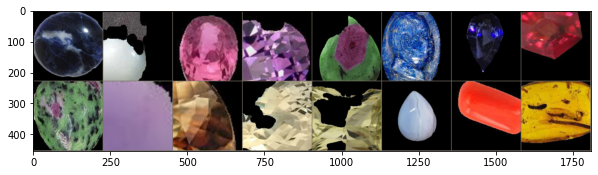

['Sodalite', 'Moonstone', 'Sapphire Pink', 'Amethyst', 'Zoisite', 'Lapis Lazuli', 'Benitoite', 'Bixbite', 'Zoisite', 'Chalcedony Blue', 'Andalusite', 'Spodumene', 'Spodumene', 'Blue Lace Agate', 'Coral', 'Amber']


In [32]:
# Define a function to display the image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.asarray(data_stds) * inp + np.asarray(data_means)
    inp = np.clip(inp, 0, 1)       # Clip to intensity outliers to [0, 1] range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


# Get a batch of training data
first_inputs, first_classes = next(iter(dataloaders['train_masked']))

# Make a grid from batch
out = torchvision.utils.make_grid(first_inputs)


plt.figure(figsize=(10, 15))
imshow(out)
plt.show()
print([class_names[x] for x in first_classes])


In [33]:
# Load a pre-trained model ResNet18
class PretrainedModel(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        model = models.resnet18(pretrained=True)
        # Create a new fully-connected layer for 68 target classes and replace the original one in Resnet18
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, output_features)
        self.model = model
        
    def forward(self, x):
        return self.model(x)

In [34]:
# Create a LRScheduler callback which scales learning rate by a factor of 0.1 every 7 epochs
lrscheduler = LRScheduler(
    policy='StepLR', step_size=7, gamma=0.1)

In [35]:
# Create a Checkpoint callback which saves the best model by by monitoring the validation accuracy.
checkpoint = Checkpoint(
    f_params='best_model.pt', monitor='valid_acc_best')

In [36]:
# Create a Freezer to freeze all weights besides the final layer named model.fc:
from skorch.callbacks import Freezer
freezer = Freezer(lambda x: not x.startswith('model.fc'))

In [37]:
# Define Convolutional Neural Network classifier
resnet18 = NeuralNetClassifier(
    PretrainedModel, 
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=16,
    max_epochs=25,
    module__output_features=85,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    iterator_valid__num_workers=2, 
    train_split=skorch.dataset.CVSplit(cv=5, stratified=True),
    callbacks=[('lrscheduler', lrscheduler),('checkpoint', checkpoint),('freezer', freezer)],
    device=device
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: CVSplit is deprecated, use the new name ValidSplit instead
  


In [38]:
# Train model
start_time = time.time()
resnet18.fit(image_datasets['train_masked'], np.array([y for X,y in image_datasets['train_masked']]))

# Display the training time
time_elapsed = time.time() - start_time
print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  epoch    train_loss    valid_acc    valid_loss    cp      lr      dur
-------  ------------  -----------  ------------  ----  ------  -------
      1        4.3007       0.1143        3.9145     +  0.0010  17.8954
      2        3.6994       0.2893        3.4196     +  0.0010  11.0874
      3        3.1863       0.3571        2.9425     +  0.0010  10.9064
      4        2.8165       0.4054        2.7161     +  0.0010  10.9083
      5        2.5188       0.4375        2.4895     +  0.0010  11.1132
      6        2.2723       0.4696        2.3152     +  0.0010  12.4025
      7        2.1217       0.4964        2.1995     +  0.0010  11.8837
      8        1.9823       0.5304        2.0809     +  0.0001  11.0724
      9        1.9239       0.5036        2.1383        0.0001  10.9760
     10        1.9214       0.5089        2.0811        0.0001  11.1607
     11        1.9350       0.5000        2.0756        0.0001  10.9545
     12        1.9497       0.5286        2.0582        0.0001  

In [39]:
# Load the ResNet model with the highest validation accuracy
best_resnet18 = NeuralNetClassifier(
    PretrainedModel, 
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=16,
    max_epochs=25,
    module__output_features=85,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    train_split=None, 
    callbacks=[ ('lrscheduler', lrscheduler),('freezer', freezer)],
    device=device
)
best_resnet18.initialize()
best_resnet18.load_params(checkpoint= Checkpoint(f_params='best_model.pt'))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
# Fit best model to training data
best_resnet18.fit(image_datasets['train_masked'], np.array([y for X,y in image_datasets['train_masked']]))

Re-initializing module because the following parameters were re-set: output_features.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss      lr      dur
-------  ------------  ------  -------
      1        4.2589  0.0010  10.8786
      2        3.5379  0.0010  10.8960
      3        3.0027  0.0010  10.6232
      4        2.6027  0.0010  10.8795
      5        2.3286  0.0010  10.9028
      6        2.1145  0.0010  10.8045
      7        1.9643  0.0010  12.5477
      8        1.8540  0.0001  10.8331
      9        1.7945  0.0001  10.7619
     10        1.7982  0.0001  10.8009
     11        1.7932  0.0001  10.8606
     12        1.7978  0.0001  10.8047
     13        1.7436  0.0001  12.5634
     14        1.7598  0.0001  10.9307
     15        1.7394  0.0000  10.8130
     16        1.7214  0.0000  10.9516
     17        1.7586  0.0000  10.8219
     18        1.7452  0.0000  10.8210
     19        1.7527  0.0000  10.7691
     20        1.7545  0.0000  10.8324
  

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=PretrainedModel(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)

In [41]:
# Separate dataset into images and targets
train_images = image_datasets['train_masked']
train_target = np.array([y for X,y in image_datasets['train_masked']])
test_images = image_datasets['test_masked']
test_target = np.array([y for X,y in image_datasets['test_masked']])

# Make predictions on training data with the best model
train_pred = best_resnet18.predict(train_images)
train_pred_proba = best_resnet18.predict_proba(train_images)

# Make predictions on test data with the best model
test_time_start = time.time()
test_pred = best_resnet18.predict(test_images)
test_time = time.time() - test_time_start 
test_pred_proba = best_resnet18.predict_proba(test_images)

# Evaluate accuracy of the best esimator with training data
train_accuracy = accuracy_score(train_target, train_pred)
    
# Evaluate accuracy of the best estimator with test data
test_accuracy = accuracy_score(test_target, test_pred)

# Evaluate top 5 accuracy of the best esimator with training data
train_top5_accuracy = top_k_accuracy_score(train_target, train_pred_proba, k=5)
    
# Evaluate top 5 accuracy of the best estimator with test data
test_top5_accuracy = top_k_accuracy_score(test_target, test_pred_proba, k=5)


print("Training accuracy = %.6f"%train_accuracy)
print("Test accuracy = %.6f"%test_accuracy)
print("Training top 5 accuracy = %.6f"%train_top5_accuracy)
print("Test top 5 accuracy = %.6f"%test_top5_accuracy)
print("Training computation time = %.6f"%time_elapsed)
print("Test computation time = %.6f" %test_time)

Training accuracy = 0.675966
Test accuracy = 0.611268
Training top 5 accuracy = 0.923820
Test top 5 accuracy = 0.892958
Training computation time = 305.411074
Test computation time = 2.209179


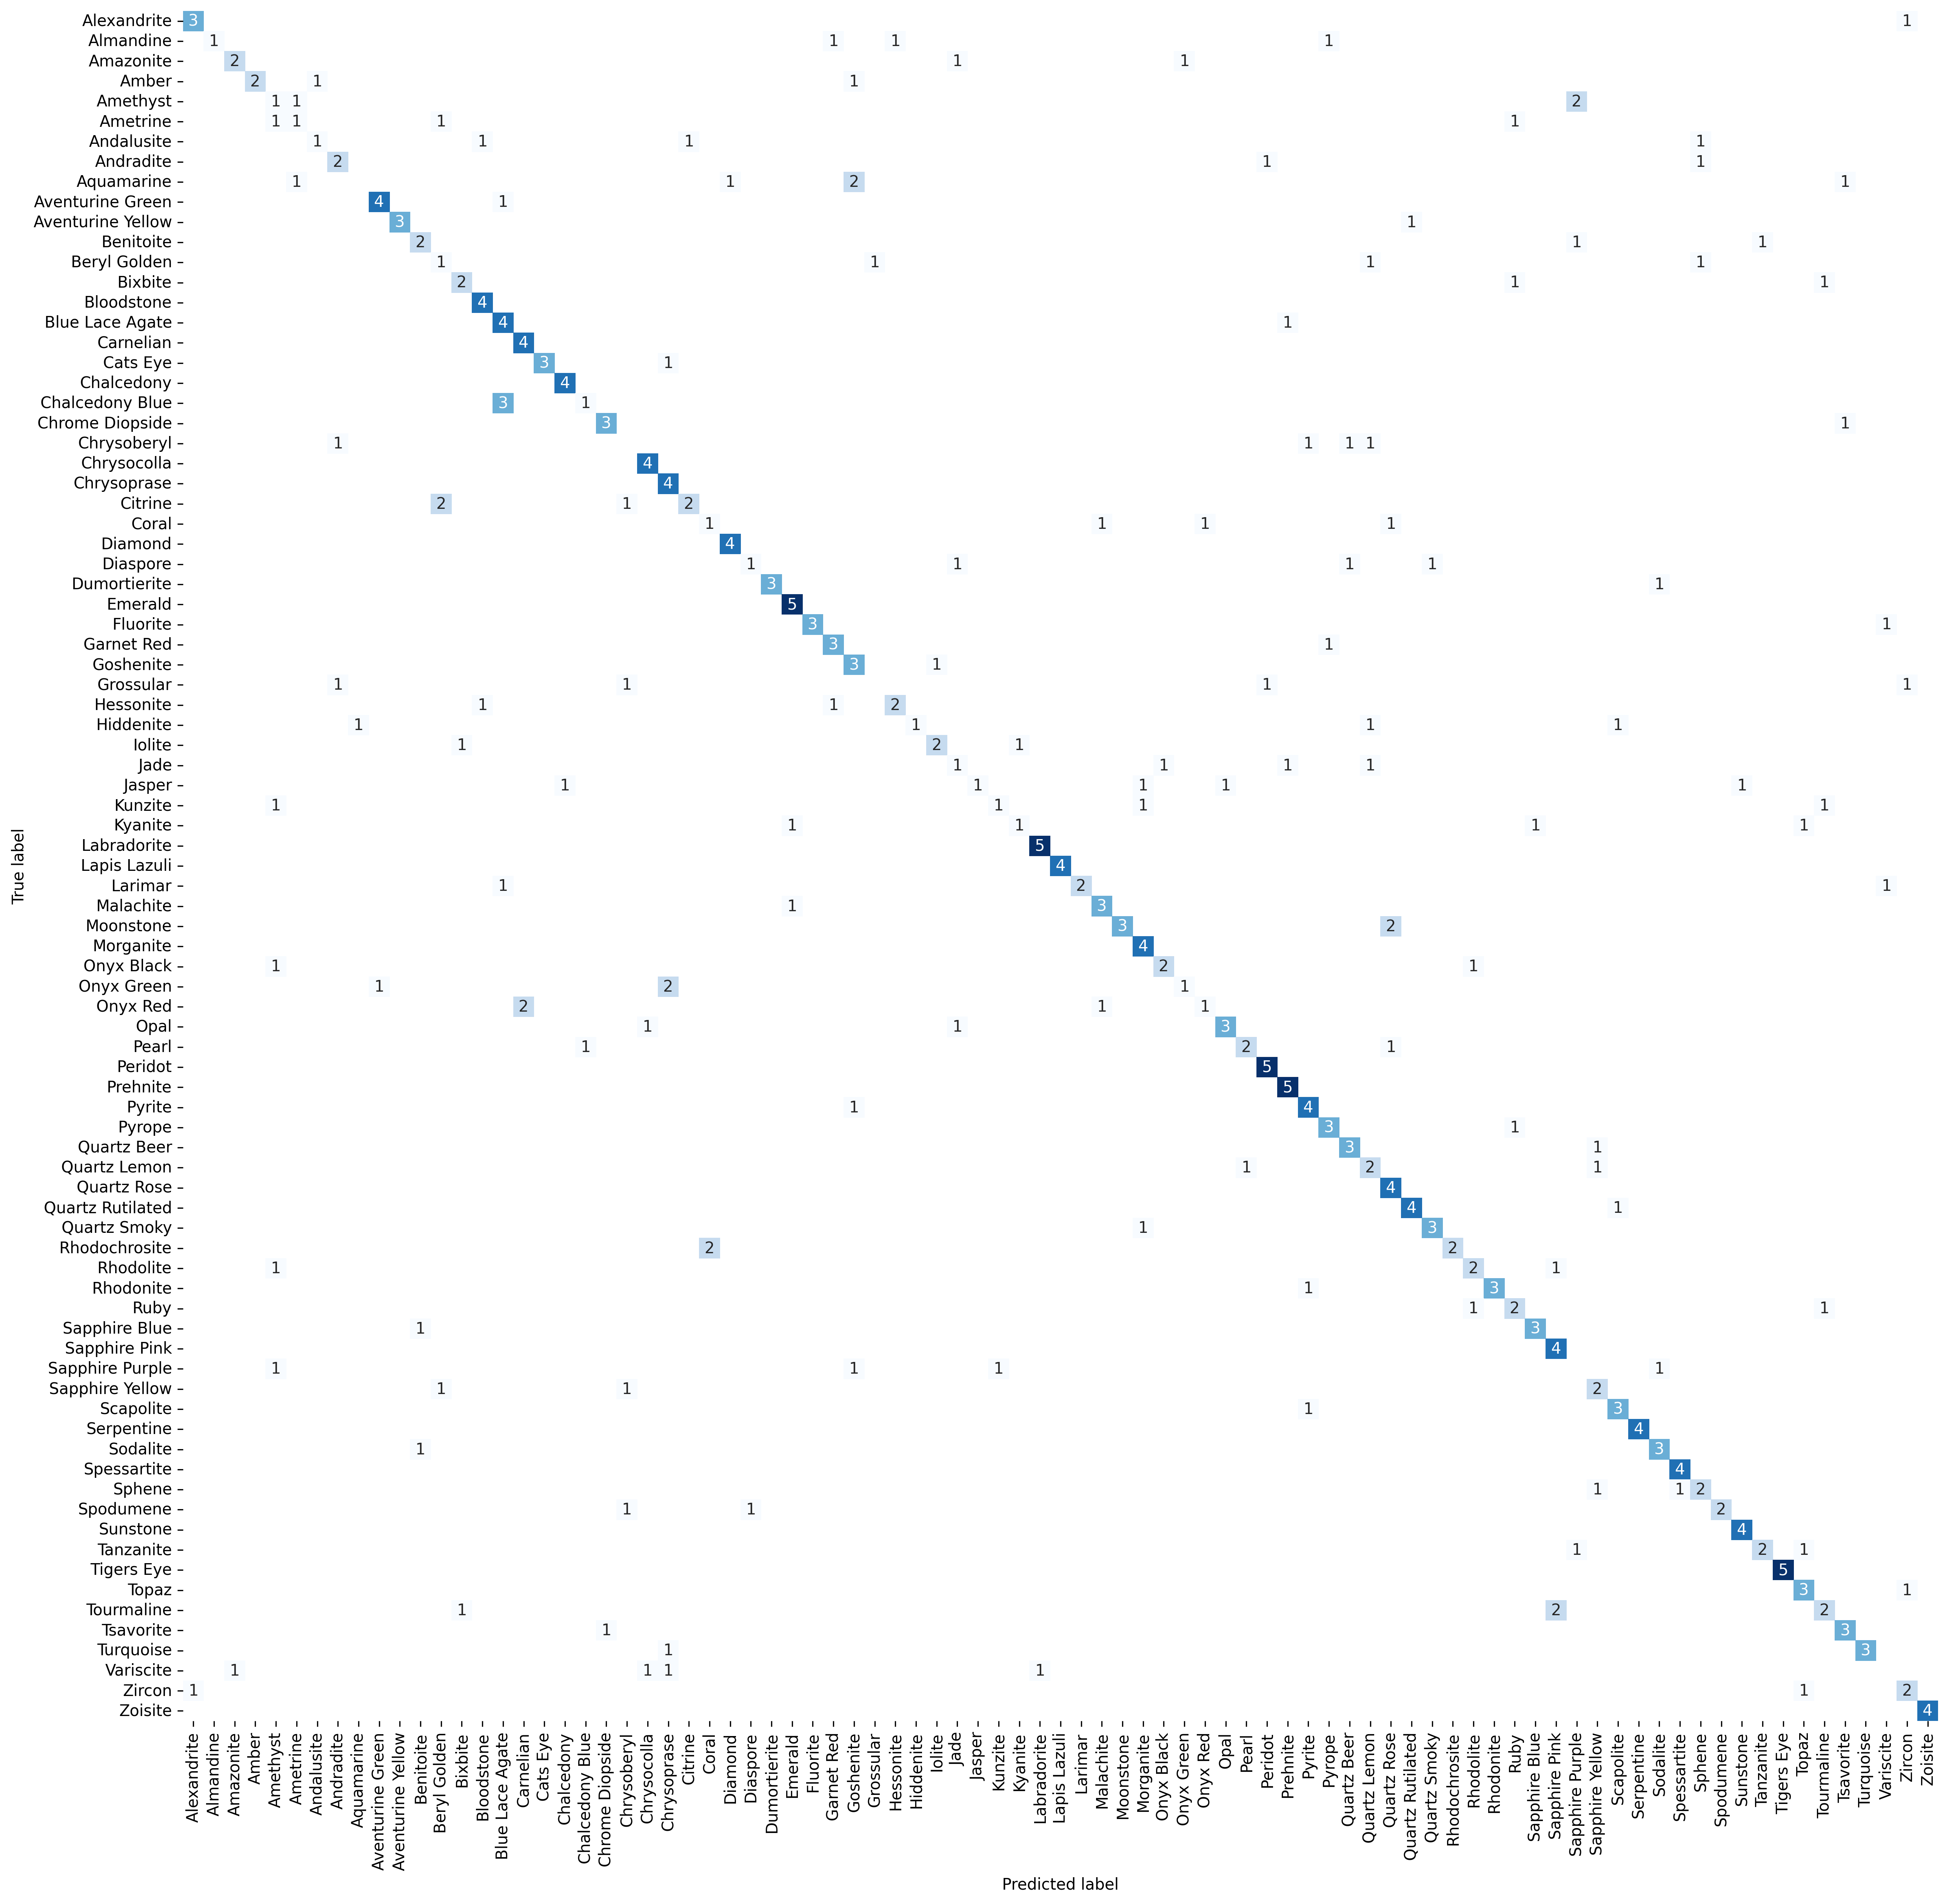

In [42]:
gemstone_classes = image_datasets['test_masked'].classes
# Display confusion matrix of the best Random Forest model
fig= plt.figure(figsize = (20,20), dpi=300)
ax = plt.subplot()
cm = confusion_matrix(test_target, test_pred)
cm_mask = np.zeros((cm.shape[0], cm.shape[0]), dtype=int)
for i in range(cm.shape[0]):
    for j in range(cm.shape[0]):
        cm_mask[i][j] = cm[i][j] == 0
sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', cbar=False, mask=cm_mask)
plt.xlabel('Predicted label')
plt.ylabel('True label')
ax.set_xticks([x+0.5 for x in range(85)])
ax.set_xticklabels(sorted(gemstone_classes), rotation=90)
ax.set_yticks([x+0.5 for x in range(85)])
ax.set_yticklabels(sorted(gemstone_classes), rotation=0)
plt.show()

In [43]:
from sklearn.metrics import classification_report
print(classification_report(test_target, test_pred, target_names=gemstone_classes))

                   precision    recall  f1-score   support

      Alexandrite       0.75      0.75      0.75         4
        Almandine       1.00      0.25      0.40         4
        Amazonite       0.67      0.50      0.57         4
            Amber       1.00      0.50      0.67         4
         Amethyst       0.17      0.25      0.20         4
         Ametrine       0.33      0.25      0.29         4
       Andalusite       0.50      0.25      0.33         4
        Andradite       0.50      0.50      0.50         4
       Aquamarine       0.00      0.00      0.00         5
 Aventurine Green       0.80      0.80      0.80         5
Aventurine Yellow       1.00      0.75      0.86         4
        Benitoite       0.50      0.50      0.50         4
     Beryl Golden       0.20      0.25      0.22         4
          Bixbite       0.50      0.50      0.50         4
       Bloodstone       0.67      1.00      0.80         4
  Blue Lace Agate       0.44      0.80      0.57       

True classes: ['Tanzanite', 'Ametrine', 'Variscite', 'Carnelian', 'Prehnite', 'Chrysoberyl', 'Almandine', 'Moonstone', 'Prehnite', 'Sapphire Blue', 'Blue Lace Agate', 'Tigers Eye', 'Beryl Golden', 'Tsavorite', 'Emerald', 'Chalcedony']
Predicted classes: ['Tanzanite', 'Ruby', 'Amazonite', 'Carnelian', 'Prehnite', 'Andradite', 'Almandine', 'Quartz Rose', 'Prehnite', 'Sapphire Blue', 'Blue Lace Agate', 'Tigers Eye', 'Beryl Golden', 'Tsavorite', 'Emerald', 'Chalcedony']


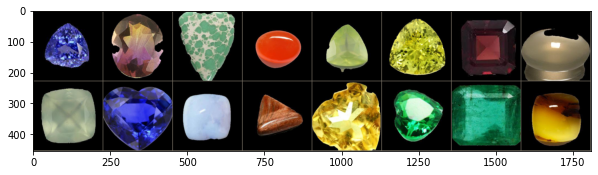

In [44]:
# Define a function to display the image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.asarray(data_stds) * inp + np.asarray(data_means)
    inp = np.clip(inp, 0, 1)       # Clip to intensity outliers to [0, 1] range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


# Get a batch of training data
first_inputs, first_classes = next(iter(dataloaders['test_masked']))

# Make a grid from batch
out = torchvision.utils.make_grid(first_inputs)

plt.figure(figsize=(10, 15))
imshow(out)
print('True classes: ' +str([class_names[x] for x in first_classes]))
print('Predicted classes: ' +str([class_names[y] for y in best_resnet18.predict(first_inputs)]))
plt.show()

In [45]:
# Load a pre-trained model ResNet50
class PretrainedModel2(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        model = models.resnet50(pretrained=True)
        # Create a new fully-connected layer for 68 target classes and replace the original one in Resnet18
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, output_features)
        self.model = model
        
    def forward(self, x):
        return self.model(x)

In [46]:
# Create a LRScheduler callback which scales learning rate by a factor of 0.1 every 7 epochs
lrscheduler = LRScheduler(
    policy='StepLR', step_size=7, gamma=0.1)

In [47]:
# Create a Checkpoint callback which saves the best model by by monitoring the validation accuracy.
checkpoint = Checkpoint(
    f_params='best_model2.pt', monitor='valid_acc_best')

In [48]:
# Create a Freezer to freeze all weights besides the final layer named model.fc:
from skorch.callbacks import Freezer
freezer = Freezer(lambda x: not x.startswith('model.fc'))

In [49]:
# Define Convolutional Neural Network classifier
resnet50 = NeuralNetClassifier(
    PretrainedModel2, 
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=16,
    max_epochs=25,
    module__output_features=85,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    iterator_valid__num_workers=2,
    train_split=skorch.dataset.CVSplit(cv=5, stratified=True),
    callbacks=[('lrscheduler', lrscheduler), ('checkpoint', checkpoint), ('freezer', freezer)],
    device=device
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: CVSplit is deprecated, use the new name ValidSplit instead
  


In [50]:
# Train model
start_time = time.time()
resnet50.fit(image_datasets['train_masked'], np.array([y for X,y in image_datasets['train_masked']]))

# Display the training time
time_elapsed = time.time() - start_time
print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

  epoch    train_loss    valid_acc    valid_loss    cp      lr      dur
-------  ------------  -----------  ------------  ----  ------  -------
      1        4.2969       0.1661        3.9473     +  0.0010  13.1212
      2        3.7585       0.3196        3.4764     +  0.0010  12.6765
      3        3.3002       0.4375        3.0359     +  0.0010  12.6947
      4        2.9382       0.4339        2.7902        0.0010  12.8436
      5        2.6404       0.4589        2.5729     +  0.0010  12.6134
      6        2.3900       0.4875        2.3704     +  0.0010  14.0695
      7        2.2083       0.5107        2.2074     +  0.0010  12.4810
      8        2.0921       0.5339        2.1830     +  0.0001  12.5746
      9        2.0680       0.5286        2.1396        0.0001  12.4665
     10        2.0240       0.5589        2.1154     +  0.0001  12.8241
     11        1.9993       0.5286        2.1544        0.0001  14.2301
     12        1.9874       0.5464        2.1305        0.0001  

In [51]:
# Load the ResNet model with the highest validation accuracy
best_resnet50 = NeuralNetClassifier(
    PretrainedModel2, 
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=16,
    max_epochs=25,
    module__output_features=85,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    train_split=None,
    callbacks=[('lrscheduler', lrscheduler), ('freezer', freezer)],
    device=device
)
best_resnet50.initialize()
best_resnet50.load_params(checkpoint= Checkpoint(f_params='best_model2.pt'))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [52]:
# Fit best model to training data
best_resnet50.fit(image_datasets['train_masked'], np.array([y for X,y in image_datasets['train_masked']]))

Re-initializing module because the following parameters were re-set: output_features.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss      lr      dur
-------  ------------  ------  -------
      1        4.2329  0.0010  12.6090
      2        3.5991  0.0010  12.5791
      3        3.0948  0.0010  12.5562
      4        2.7154  0.0010  12.4646
      5        2.4248  0.0010  12.5205
      6        2.2035  0.0010  12.4036
      7        2.0361  0.0010  12.5551
      8        1.9023  0.0001  12.5037
      9        1.8809  0.0001  12.6612
     10        1.8421  0.0001  12.5641
     11        1.8522  0.0001  14.1316
     12        1.8614  0.0001  12.6568
     13        1.8499  0.0001  12.6872
     14        1.8143  0.0001  12.6142
     15        1.8096  0.0000  12.6721
     16        1.7774  0.0000  14.1200
     17        1.7997  0.0000  12.5095
     18        1.8158  0.0000  12.5775
     19        1.8015  0.0000  12.7115
     20        1.7826  0.0000  12.6900
  

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=PretrainedModel2(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, 

In [53]:
# Separate dataset into images and targets
train_images = image_datasets['train_masked']
train_target = np.array([y for X,y in image_datasets['train_masked']])
test_images = image_datasets['test_masked']
test_target = np.array([y for X,y in image_datasets['test_masked']])

# Make predictions with the best model on training data
train_pred = best_resnet50.predict(train_images)
train_pred_proba = best_resnet50.predict_proba(train_images)

# Make predictions with the best model on test data
test_time_start = time.time()
test_pred = best_resnet50.predict(test_images)
test_time = time.time() - test_time_start 
test_pred_proba = best_resnet50.predict_proba(test_images)

# Evaluate accuracy of the best esimator with training data
train_accuracy = accuracy_score(train_target, train_pred)
    
# Evaluate accuracy of the best estimator with test data
test_accuracy = accuracy_score(test_target, test_pred)

# Evaluate top 5 accuracy of the best esimator with training data
train_top5_accuracy = top_k_accuracy_score(train_target, train_pred_proba, k=5)
    
# Evaluate top 5 accuracy of the best estimator with test data
test_top5_accuracy = top_k_accuracy_score(test_target, test_pred_proba, k=5)


print("Training accuracy = %.6f"%train_accuracy)
print("Test accuracy = %.6f"%test_accuracy)
print("Training top 5 accuracy = %.6f"%train_top5_accuracy)
print("Test top 5 accuracy = %.6f"%test_top5_accuracy)
print("Training computation time = %.6f"%time_elapsed)
print("Test computation time = %.6f" %test_time)

Training accuracy = 0.688484
Test accuracy = 0.630986
Training top 5 accuracy = 0.937768
Test top 5 accuracy = 0.909859
Training computation time = 338.660459
Test computation time = 2.872102


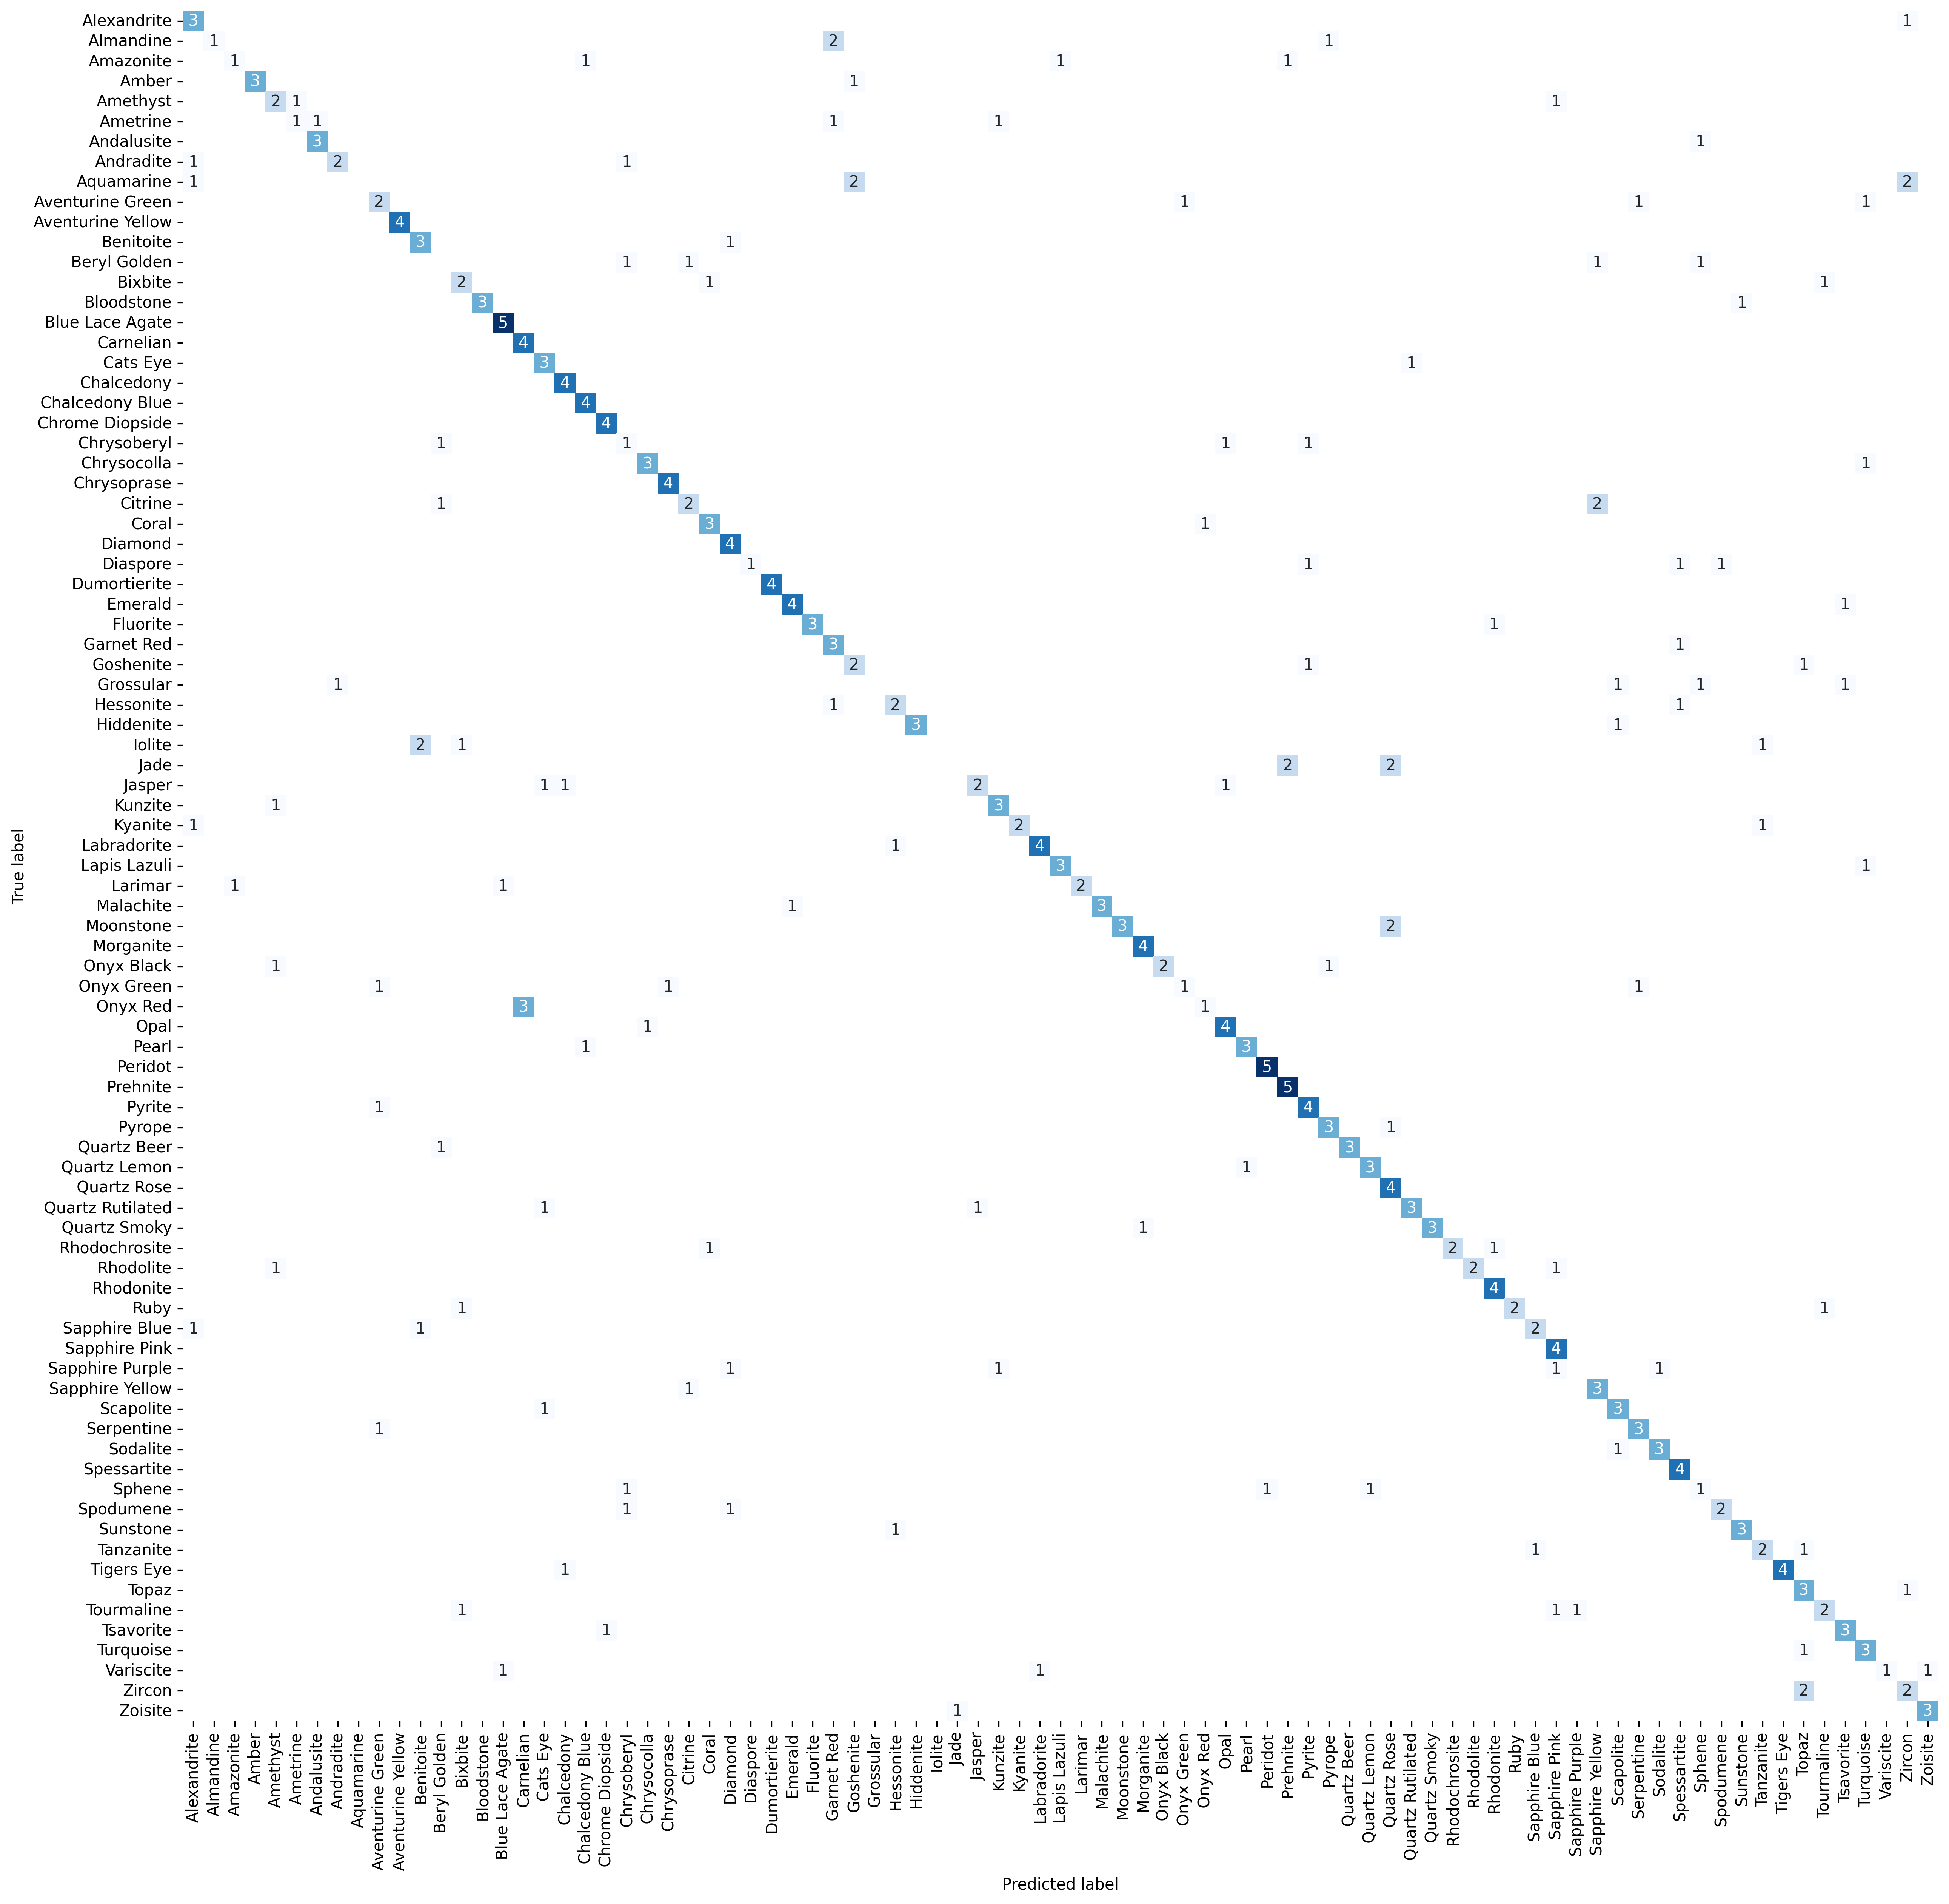

In [54]:
gemstone_classes = image_datasets['test_masked'].classes
# Display confusion matrix of the best Random Forest model
fig= plt.figure(figsize = (20,20), dpi=300)
ax = plt.subplot()
cm = confusion_matrix(test_target, test_pred)
cm_mask = np.zeros((cm.shape[0], cm.shape[0]), dtype=int)
for i in range(cm.shape[0]):
    for j in range(cm.shape[0]):
        cm_mask[i][j] = cm[i][j] == 0
sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', cbar=False, mask=cm_mask)
plt.xlabel('Predicted label')
plt.ylabel('True label')
ax.set_xticks([x+0.5 for x in range(85)])
ax.set_xticklabels(sorted(gemstone_classes), rotation=90)
ax.set_yticks([x+0.5 for x in range(85)])
ax.set_yticklabels(sorted(gemstone_classes), rotation=0)
plt.show()

In [55]:
from sklearn.metrics import classification_report
print(classification_report(test_target, test_pred, target_names=gemstone_classes))

                   precision    recall  f1-score   support

      Alexandrite       0.43      0.75      0.55         4
        Almandine       1.00      0.25      0.40         4
        Amazonite       0.50      0.25      0.33         4
            Amber       1.00      0.75      0.86         4
         Amethyst       0.40      0.50      0.44         4
         Ametrine       0.50      0.25      0.33         4
       Andalusite       0.75      0.75      0.75         4
        Andradite       0.67      0.50      0.57         4
       Aquamarine       0.00      0.00      0.00         5
 Aventurine Green       0.40      0.40      0.40         5
Aventurine Yellow       1.00      1.00      1.00         4
        Benitoite       0.50      0.75      0.60         4
     Beryl Golden       0.00      0.00      0.00         4
          Bixbite       0.40      0.50      0.44         4
       Bloodstone       1.00      0.75      0.86         4
  Blue Lace Agate       0.71      1.00      0.83       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


True classes: ['Beryl Golden', 'Bloodstone', 'Andalusite', 'Sapphire Yellow', 'Sapphire Pink', 'Chalcedony Blue', 'Pearl', 'Chrysoprase', 'Onyx Green', 'Kunzite', 'Moonstone', 'Goshenite', 'Chalcedony Blue', 'Pyrite', 'Onyx Black', 'Chrysoberyl']
Predicted classes: ['Sphene', 'Bloodstone', 'Andalusite', 'Sapphire Yellow', 'Sapphire Pink', 'Chalcedony Blue', 'Pearl', 'Chrysoprase', 'Serpentine', 'Amethyst', 'Moonstone', 'Goshenite', 'Chalcedony Blue', 'Pyrite', 'Amethyst', 'Opal']


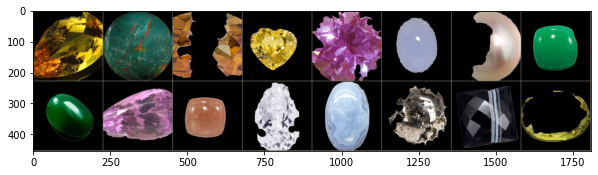

In [56]:
# Define a function to display the image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.asarray(data_stds) * inp + np.asarray(data_means)
    inp = np.clip(inp, 0, 1)       # Clip to intensity outliers to [0, 1] range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


# Get a batch of training data
first_inputs, first_classes = next(iter(dataloaders['test_masked']))

# Make a grid from batch
out = torchvision.utils.make_grid(first_inputs)

plt.figure(figsize=(10, 15))
imshow(out)
print('True classes: ' +str([class_names[x] for x in first_classes]))
print('Predicted classes: ' +str([class_names[y] for y in best_resnet50.predict(first_inputs)]))

In [63]:
# Load a pre-trained model DenseNet
class PretrainedModel2(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        model = models.resnext101_32x8d(pretrained=True)
        # Create a new fully-connected layer for 68 target classes and replace the original one in Resnet18
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, output_features)
        self.model = model
        
    def forward(self, x):
        return self.model(x)

In [64]:
# Create a LRScheduler callback which scales learning rate by a factor of 0.1 every 7 epochs
lrscheduler = LRScheduler(
    policy='StepLR', step_size=7, gamma=0.1)

In [65]:
# Create a Checkpoint callback which saves the best model by by monitoring the validation accuracy.
checkpoint = Checkpoint(
    f_params='best_model2.pt', monitor='valid_acc_best')

In [66]:
# Create a Freezer to freeze all weights besides the final layer named model.fc:
from skorch.callbacks import Freezer
freezer = Freezer(lambda x: not x.startswith('model.fc'))

In [69]:
# Define Convolutional Neural Network classifier
resnext = NeuralNetClassifier(
    PretrainedModel2, 
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=16,
    max_epochs=25,
    module__output_features=85,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    iterator_valid__num_workers=2,
    train_split=skorch.dataset.CVSplit(cv=5, stratified=True),
    callbacks=[('lrscheduler', lrscheduler), ('checkpoint', checkpoint), ('freezer', freezer)],
    device=device
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: CVSplit is deprecated, use the new name ValidSplit instead
  


In [70]:
# Train model
start_time = time.time()
resnext.fit(image_datasets['train_masked'], np.array([y for X,y in image_datasets['train_masked']]))

# Display the training time
time_elapsed = time.time() - start_time
print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  epoch    train_loss    valid_acc    valid_loss    cp      lr      dur
-------  ------------  -----------  ------------  ----  ------  -------
      1        4.2442       0.1696        3.8896     +  0.0010  43.2115
      2        3.5802       0.3518        3.3182     +  0.0010  41.6439
      3        3.0363       0.4607        2.8763     +  0.0010  42.2561
      4        2.5996       0.4732        2.5781     +  0.0010  41.7737
      5        2.2911       0.5018        2.3615     +  0.0010  41.6532
      6        2.0628       0.5286        2.1856     +  0.0010  41.9285
      7        1.8444       0.5536        2.0249     +  0.0010  41.6819
      8        1.7283       0.5679        1.9771     +  0.0001  41.8623
      9        1.6980       0.5571        1.9690        0.0001  42.0131
     10        1.6630       0.6018        1.9193     +  0.0001  41.7768
     11        1.6492       0.5804        1.9586        0.0001  41.6869
     12        1.6972       0.5768        1.9216        0.0001  

In [71]:
# Load the ResNet model with the highest validation accuracy
best_resnext = NeuralNetClassifier(
    PretrainedModel2, 
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=16,
    max_epochs=25,
    module__output_features=85,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    train_split=None,
    callbacks=[('lrscheduler', lrscheduler), ('freezer', freezer)],
    device=device
)
best_resnext.initialize()
best_resnext.load_params(checkpoint= Checkpoint(f_params='best_model2.pt'))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [72]:
# Fit best model to training data
best_resnext.fit(image_datasets['train_masked'], np.array([y for X,y in image_datasets['train_masked']]))

Re-initializing module because the following parameters were re-set: output_features.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss      lr      dur
-------  ------------  ------  -------
      1        4.1605  0.0010  43.2047
      2        3.3855  0.0010  41.2294
      3        2.8006  0.0010  42.3545
      4        2.3988  0.0010  41.5538
      5        2.1008  0.0010  41.8329
      6        1.8509  0.0010  42.1294
      7        1.7154  0.0010  41.8345
      8        1.5928  0.0001  41.5419
      9        1.5697  0.0001  41.7406
     10        1.5470  0.0001  41.9791
     11        1.5403  0.0001  42.0296
     12        1.5229  0.0001  41.9469
     13        1.5180  0.0001  41.9963
     14        1.5033  0.0001  41.7319
     15        1.4890  0.0000  41.7205
     16        1.5146  0.0000  41.8176
     17        1.4730  0.0000  41.7675
     18        1.4717  0.0000  41.6758
     19        1.4841  0.0000  41.7580
     20        1.4878  0.0000  41.8806
  

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=PretrainedModel2(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0

In [73]:
# Separate dataset into images and targets
train_images = image_datasets['train_masked']
train_target = np.array([y for X,y in image_datasets['train_masked']])
test_images = image_datasets['test_masked']
test_target = np.array([y for X,y in image_datasets['test_masked']])

# Make predictions with the best model on training data
train_pred = best_resnext.predict(train_images)
train_pred_proba = best_resnext.predict_proba(train_images)

# Make predictions with the best model on test data
test_time_start = time.time()
test_pred = best_resnext.predict(test_images)
test_time = time.time() - test_time_start 
test_pred_proba = best_resnext.predict_proba(test_images)

# Evaluate accuracy of the best esimator with training data
train_accuracy = accuracy_score(train_target, train_pred)
    
# Evaluate accuracy of the best estimator with test data
test_accuracy = accuracy_score(test_target, test_pred)

# Evaluate top 5 accuracy of the best esimator with training data
train_top5_accuracy = top_k_accuracy_score(train_target, train_pred_proba, k=5)
    
# Evaluate top 5 accuracy of the best estimator with test data
test_top5_accuracy = top_k_accuracy_score(test_target, test_pred_proba, k=5)


print("Training accuracy = %.6f"%train_accuracy)
print("Test accuracy = %.6f"%test_accuracy)
print("Training top 5 accuracy = %.6f"%train_top5_accuracy)
print("Test top 5 accuracy = %.6f"%test_top5_accuracy)
print("Training computation time = %.6f"%time_elapsed)
print("Test computation time = %.6f" %test_time)

Training accuracy = 0.752861
Test accuracy = 0.676056
Training top 5 accuracy = 0.957797
Test top 5 accuracy = 0.909859
Training computation time = 1069.928930
Test computation time = 6.914276
